# Projeto de  Imagem  --- Jeito 2
Neste notebook vamos a mostrar como fazer um projeto simples de deep learning passo por passo 


*   Primeiro montar a base de dados 
*   Conhecer a base de dados 
*   Ver como estão nossas classes
*   Utilizar transfer learning
*   Data generation e data augmentation
*   ver metricas e inferir





##Baixo os pesos de minha arquitetura 

## &nbsp;&nbsp;  InceptionNets

Também conhecido como GoogleNet, consiste em um total de 22 camadas e foi o modelo vencedor do desafio de rede de imagens de 2014.

- Módulos de iniciação são o bloco fundamental de InceptionNets. A ideia principal do módulo de iniciação é projetar uma boa topologia de rede local (rede dentro de uma rede)
- Esses módulos ou blocos atuam como o extrator de recursos de vários níveis em que convoluções de tamanhos diferentes são obtidas para criar um mapa de recursos diversificado
- Os módulos de iniciação também consistem em blocos de convolução 1 x 1 cuja função é realizar a redução dimensional.
- Ao realizar a convolução 1x1, o bloco inicial preserva as dimensões espaciais, mas reduz a profundidade. Portanto, as dimensões gerais da rede não aumentam exponencialmente.
- Além da camada de saída regular, esta rede também consiste em duas saídas de classificação auxiliares que são usadas para injetar gradientes nas camadas inferiores.

<br> <br>

O módulo de iniciação é mostrado na figura a seguir:

![](https://hackathonprojects.files.wordpress.com/2016/09/inception_implement.png?w=649&h=337)

A arquitetura completa é mostrada abaixo: 

![](https://cdn-images-1.medium.com/max/2000/1*uXfC5fcbDsL0TJG4T8PsVw.png)
### Pre-Trained Model : InceptionV3

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-02-14 19:46:31--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 172.217.214.128, 108.177.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

inception_v3_weight 100%[===================>]  83.84M   138MB/s    in 0.6s    

2022-02-14 19:46:31 (138 MB/s) - ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import numpy as np
import matplotlib.pylab as plt

##Pesos da rede 

In [ ]:
weights1="/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

## &nbsp;&nbsp;  Conheciendo os dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive/BI-Temp'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

Mounted at /content/drive


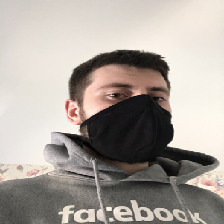

In [ ]:
imagem=load_img('mask/train/with_mask/image_189.png', target_size=(224,224,3));imagem

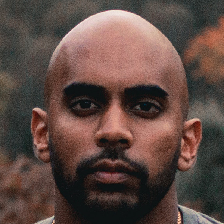

In [ ]:
imagem=load_img('mask/train/without_mask/image_189.png', target_size=(224,224,3));imagem

## Faço um reshape na entrada 

##  Transfer Learning

<br>

Vejamos a implementação do aprendizado por transferência usando recursos de modelo pré-treinados.

Trunco a rede e passa os dados



In [ ]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False,    ########## NAO PEGOU A FC
                                weights = None)

pre_trained_model.load_weights(weights1)

for layer in pre_trained_model.layers:
    layer.trainable = False
    # FALSE GARANTE QUE A REDE USADA NAO VAI TER SEUS PESOS RETREINADOS

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 3, 3, 2048)


## Data Augmentation
###  Preparação do conjunto de dados

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


test_datagen = ImageDataGenerator(rescale = 1.0/255.)


train_generator = train_datagen.flow_from_directory("mask/train/",
                                                    batch_size = 10,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150)) 
# VAI IMPRIMIR A QUANTIDADE DO TRAIN    

validation_generator =  test_datagen.flow_from_directory( "mask/test/",
                                                          batch_size  = 10,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))
# VAI IMPRIMIR A QUANTIDADE DO VALID

Found 329 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [ ]:
train_generator.__len__()

# 380 AMOSTRAS DIVIDIDO PELO BATCH SIZE 380/10

33

## Agora criamos uma rede com a ultima camada (classificação) 

In [ ]:
from tensorflow.keras.optimizers import Adam
#last_output = last_layer.output

# x é minha nova rede

x = layers.Flatten()(last_output)

x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)                  
x = layers.Dense  (1, activation='sigmoid')(x)     # somente uma saída       

model = Model( pre_trained_model.input, x)         # Model (início,fim) meu novo modelo

model.compile(optimizer = Adam(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

## Agora rodamos o modelo

In [ ]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 20,
            epochs = 10,
            validation_steps = 10,
            verbose = 1)

Epoch 1/10
20/20 [==============================] - 73s 3s/step - loss: 0.6600 - accuracy: 0.8450 - val_loss: 0.0429 - val_accuracy: 0.9833
Epoch 2/10
20/20 [==============================] - 16s 826ms/step - loss: 0.1450 - accuracy: 0.9548
Epoch 3/10
20/20 [==============================] - 10s 500ms/step - loss: 0.3554 - accuracy: 0.9397
Epoch 4/10
20/20 [==============================] - 8s 401ms/step - loss: 0.5273 - accuracy: 0.9100
Epoch 5/10
20/20 [==============================] - 7s 354ms/step - loss: 0.4103 - accuracy: 0.9450
Epoch 6/10
20/20 [==============================] - 6s 318ms/step - loss: 0.3366 - accuracy: 0.9500
Epoch 7/10
20/20 [==============================] - 6s 286ms/step - loss: 0.3210 - accuracy: 0.9497
Epoch 8/10
20/20 [==============================] - 6s 281ms/step - loss: 0.0358 - accuracy: 0.9899
Epoch 9/10
20/20 [==============================] - 6s 278ms/step - loss: 0.1837 - accuracy: 0.9600
Epoch 10/10
20/20 [==============================] - 5s 27

##Vemos como se comportou nosso modelo

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

def PlotHistory(history):    
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## indicadores de desempenho

In [ ]:
score = model.evaluate_generator(validation_generator, verbose=0)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.



Test score: 0.3134194016456604
Test accuracy: 0.9833333492279053


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


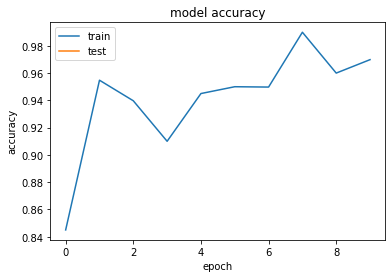

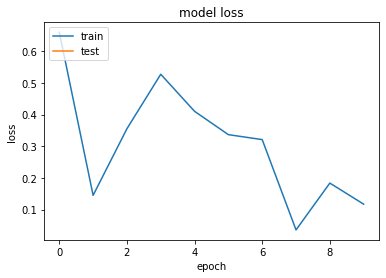

In [ ]:
PlotHistory(history)

##Inferencia do modelo

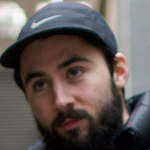

In [ ]:


imagem=load_img('mask/train/without_mask/image_173.png', target_size=(150,150,3));
imagem

In [ ]:
imagem=np.array(imagem)


cls  = model.predict(imagem[np.newaxis,:,:,:]/255.)
print(cls)

[[0.9999999]]


In [ ]:
cls[0]

array([0.9999999], dtype=float32)